# Comparación entre bandas SeaWiFS(490) y MODIS(10)

Primero cargaremos las librerias necesarias.

In [24]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from scipy.stats import kde

import seaborn as sns
plt.style.use('seaborn')


Cargaremos en memoria los datos de los sensores para enero de 2003. Los archivos fueron modificados para representar la pura matriz de datos.

In [2]:
# Para el sensor SeaWiFS.

with open('Composicion_(Lt_490).txt') as archivo_seawifs:
    for _ in range(5):
        # Ignoramos los primeros 5 renglones del archivo.
        archivo_seawifs.readline()
    # Separamos los datos en una matriz.
    datos_seawifs = np.array([archivo_seawifs.readline().split()
                              for _ in range(127)])

# Desenrrollamos y convertimos a reales.
datos_seawifs = datos_seawifs.ravel()
datos_seawifs = np.array([float(dat) for dat in datos_seawifs])

In [3]:
# Para el sensor MODIS. Es lo mismo pero con otro archivo.

with open('Composicion_(Band 10).txt') as archivo_modis:
    for _ in range(5):
        # Ignoramos los primeros 5 renglones del archivo.
        archivo_modis.readline()
    # Separamos los datos en una matriz.
    datos_modis = np.array([archivo_modis.readline().split()
                              for _ in range(127)])

# Desenrrollamos y convertimos a reales.
datos_modis = datos_modis.ravel()
datos_modis = np.array([float(dat) for dat in datos_modis])

Ahora calculamos la regresión lineal para los datos de ambos sensores.

In [4]:
# Calculamos los coeficientes del ajuste lineal
a, b = np.polyfit(datos_seawifs, datos_modis, 1)
# Calculamos el coeficiente de correlación
r = np.corrcoef(datos_seawifs, datos_modis)

Y graficamos los resultados.

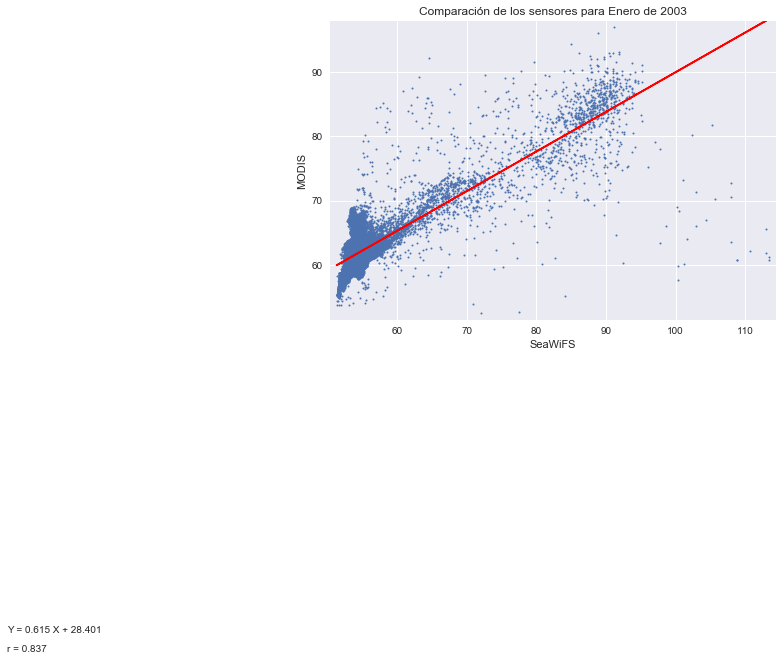

In [84]:
plt.plot(datos_seawifs, datos_modis, linestyle='', marker='o', markersize=2)

plt.xlim(np.min(datos_seawifs) - 1, np.max(datos_seawifs) + 1)
plt.ylim(np.min(datos_modis) - 1, np.max(datos_modis) + 1)

plt.xlabel("SeaWiFS")
plt.ylabel("MODIS")

plt.title("Comparación de los sensores para Enero de 2003")

plt.text(4, 0, 'r = {0:2.3f}'.format(r[0,1]))
plt.text(4, 3, 'Y = {0:2.3f} X + {1:2.3f}'.format(a, b))

# El ajuste calculado.
plt.plot(datos_seawifs, a * datos_seawifs + b,"r")

## Otras formas de verlo

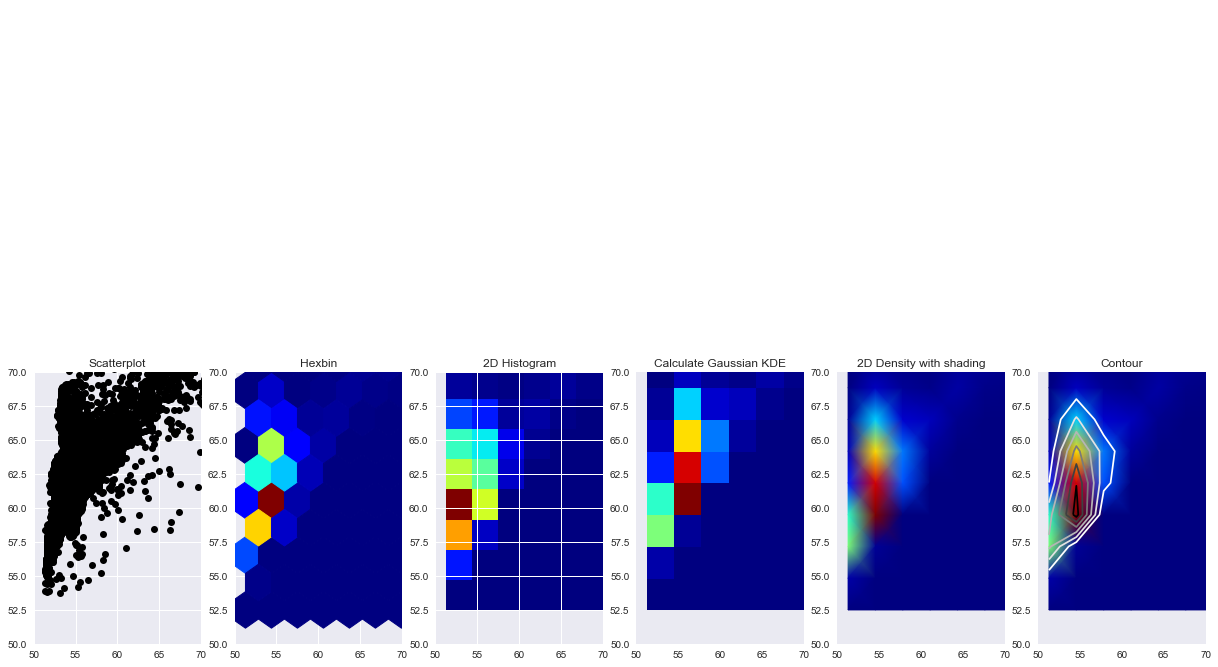

In [61]:
v=[50,70,50,70]

# Create a figure with 6 plot areas
fig, axes = plt.subplots(ncols=6, nrows=1, figsize=(21, 5))

x , y= datos_seawifs, datos_modis
# Everything sarts with a Scatterplot
axes[0].set_title('Scatterplot')
axes[0].axis(v)
axes[0].plot(x, y, 'ko')
# As you can see there is a lot of overplottin here!
 
# Thus we can cut the plotting window in several hexbins
nbins = 20
axes[1].set_title('Hexbin')
axes[1].axis(v)
axes[1].hexbin(x, y, gridsize=nbins, cmap="jet")

 
# 2D Histogram
axes[2].set_title('2D Histogram')
axes[2].hist2d(x, y, bins=nbins, cmap="jet")
axes[2].axis(v)
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k = kde.gaussian_kde((x,y))
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# plot a density
axes[3].set_title('Calculate Gaussian KDE')
axes[3].axis(v)
axes[3].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap="jet")
 
# add shading
axes[4].set_title('2D Density with shading')
axes[4].axis(v)
axes[4].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap="jet")
 
# contour
axes[5].set_title('Contour')
axes[5].axis(v)
axes[5].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap="jet")
axes[5].contour(xi, yi, zi.reshape(xi.shape) )


### Comparación para el mes de febrero

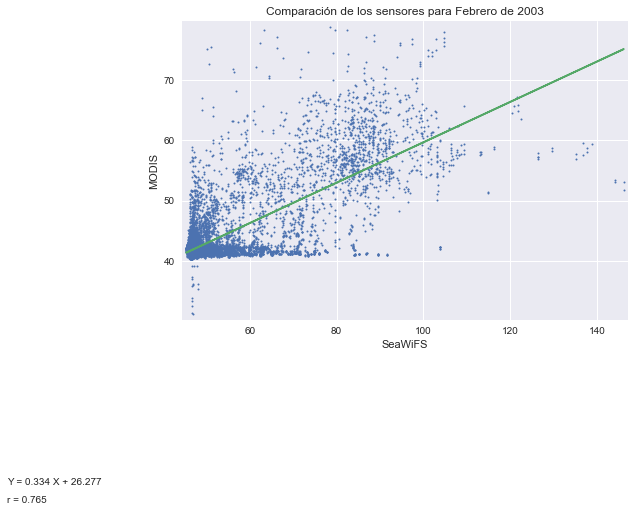

In [72]:
# Para el sensor SeaWiFS.

with open('FEBRERO_2003/SeaWiFS/3_Bandas/Composicion (Lt_490).txt') as archivo_seawifs:
    for _ in range(5):
        # Ignoramos los primeros 5 renglones del archivo.
        archivo_seawifs.readline()
    # Separamos los datos en una matriz.
    datos_seawifs = np.array([archivo_seawifs.readline().split()
                              for _ in range(127)])

# Desenrrollamos y convertimos a reales.
datos_seawifs = datos_seawifs.ravel()
datos_seawifs = np.array([float(dat) for dat in datos_seawifs])

# Para el sensor MODIS. Es lo mismo pero con otro archivo.

with open('FEBRERO_2003/MODIS/3_Bandas/Composicion (B10).txt') as archivo_modis:
    for _ in range(5):
        # Ignoramos los primeros 5 renglones del archivo.
        archivo_modis.readline()
    # Separamos los datos en una matriz.
    datos_modis = np.array([archivo_modis.readline().split()
                              for _ in range(127)])

# Desenrrollamos y convertimos a reales.
datos_modis = datos_modis.ravel()
datos_modis = np.array([float(dat) for dat in datos_modis])

# Calculamos los coeficientes del ajuste lineal
a, b = np.polyfit(datos_seawifs, datos_modis, 1)
# Calculamos el coeficiente de correlación
r = np.corrcoef(datos_seawifs, datos_modis)

plt.plot(datos_seawifs, datos_modis, linestyle='', marker='o', markersize=2)

plt.xlim(np.min(datos_seawifs) - 1, np.max(datos_seawifs) + 1)
plt.ylim(np.min(datos_modis) - 1, np.max(datos_modis) + 1)

plt.xlabel("SeaWiFS")
plt.ylabel("MODIS")

plt.title("Comparación de los sensores para Febrero de 2003")

plt.text(4, 0, 'r = {0:2.3f}'.format(r[0,1]))
plt.text(4, 3, 'Y = {0:2.3f} X + {1:2.3f}'.format(a, b))

# El ajuste calculado.
plt.plot(datos_seawifs, a * datos_seawifs + b)

### Comparación para el mes de Marzo

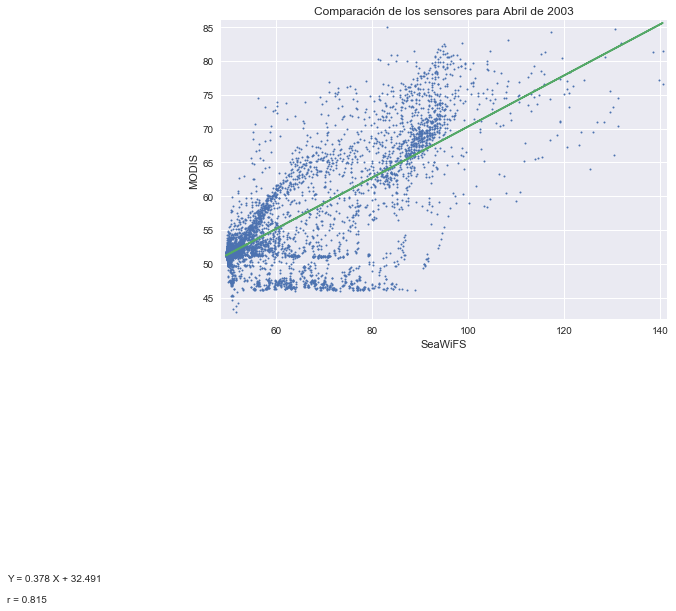

In [71]:
# Para el sensor SeaWiFS.

with open('MARZO 2003/SeaWiFS/Composicion (Lt_490).txt') as archivo_seawifs:
    for _ in range(5):
        # Ignoramos los primeros 5 renglones del archivo.
        archivo_seawifs.readline()
    # Separamos los datos en una matriz.
    datos_seawifs = np.array([archivo_seawifs.readline().split()
                              for _ in range(127)])

# Desenrrollamos y convertimos a reales.
datos_seawifs = datos_seawifs.ravel()
datos_seawifs = np.array([float(dat) for dat in datos_seawifs])

# Para el sensor MODIS. Es lo mismo pero con otro archivo.

with open('MARZO 2003/MODIS/Composicion (B10).txt') as archivo_modis:
    for _ in range(5):
        # Ignoramos los primeros 5 renglones del archivo.
        archivo_modis.readline()
    # Separamos los datos en una matriz.
    datos_modis = np.array([archivo_modis.readline().split()
                              for _ in range(127)])

# Desenrrollamos y convertimos a reales.
datos_modis = datos_modis.ravel()
datos_modis = np.array([float(dat) for dat in datos_modis])

# Calculamos los coeficientes del ajuste lineal
a, b = np.polyfit(datos_seawifs, datos_modis, 1)
# Calculamos el coeficiente de correlación
r = np.corrcoef(datos_seawifs, datos_modis)

plt.plot(datos_seawifs, datos_modis, linestyle='', marker='o', markersize=2)

plt.xlim(np.min(datos_seawifs) - 1, np.max(datos_seawifs) + 1)
plt.ylim(np.min(datos_modis) - 1, np.max(datos_modis) + 1)

plt.xlabel("SeaWiFS")
plt.ylabel("MODIS")

plt.title("Comparación de los sensores para Abril de 2003")

plt.text(4, 0, 'r = {0:2.3f}'.format(r[0,1]))
plt.text(4, 3, 'Y = {0:2.3f} X + {1:2.3f}'.format(a, b))

# El ajuste calculado.
plt.plot(datos_seawifs, a * datos_seawifs + b)

### Comparación para el mes de Abril

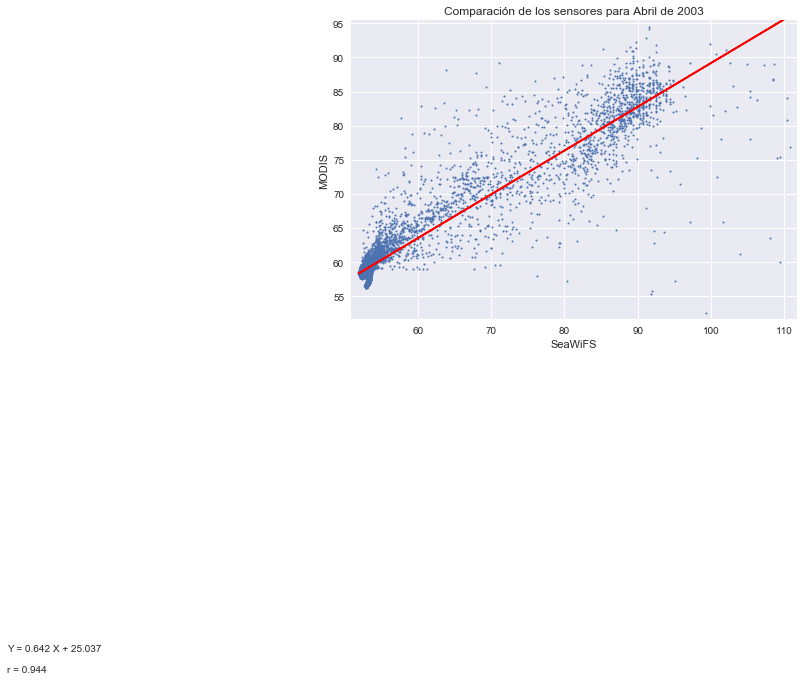

In [80]:
# Para el sensor SeaWiFS.

with open('ABRIL 2003/SeaWiFS/Composicion (Lt_490).txt') as archivo_seawifs:
    for _ in range(5):
        # Ignoramos los primeros 5 renglones del archivo.
        archivo_seawifs.readline()
    # Separamos los datos en una matriz.
    datos_seawifs = np.array([archivo_seawifs.readline().split()
                              for _ in range(127)])

# Desenrrollamos y convertimos a reales.
datos_seawifs = datos_seawifs.ravel()
datos_seawifs = np.array([float(dat) for dat in datos_seawifs])

# Para el sensor MODIS. Es lo mismo pero con otro archivo.

with open('ABRIL 2003/MODIS/Composicion (B10).txt') as archivo_modis:
    for _ in range(5):
        # Ignoramos los primeros 5 renglones del archivo.
        archivo_modis.readline()
    # Separamos los datos en una matriz.
    datos_modis = np.array([archivo_modis.readline().split()
                              for _ in range(127)])

# Desenrrollamos y convertimos a reales.
datos_modis = datos_modis.ravel()
datos_modis = np.array([float(dat) for dat in datos_modis])

# Calculamos los coeficientes del ajuste lineal
a, b = np.polyfit(datos_seawifs, datos_modis, 1)
# Calculamos el coeficiente de correlación
r = np.corrcoef(datos_seawifs, datos_modis)

plt.plot(datos_seawifs, datos_modis, linestyle='', marker='o', markersize=2)

plt.xlim(np.min(datos_seawifs) - 1, np.max(datos_seawifs) + 1)
plt.ylim(np.min(datos_modis) - 1, np.max(datos_modis) + 1)

plt.xlabel("SeaWiFS")
plt.ylabel("MODIS")

plt.title("Comparación de los sensores para Abril de 2003")

plt.text(4, 0, 'r = {0:2.3f}'.format(r[0,1]))
plt.text(4, 3, 'Y = {0:2.3f} X + {1:2.3f}'.format(a, b))

# El ajuste calculado.
plt.plot(datos_seawifs, a * datos_seawifs + b,"r")

### Comparación para el mes de Mayo

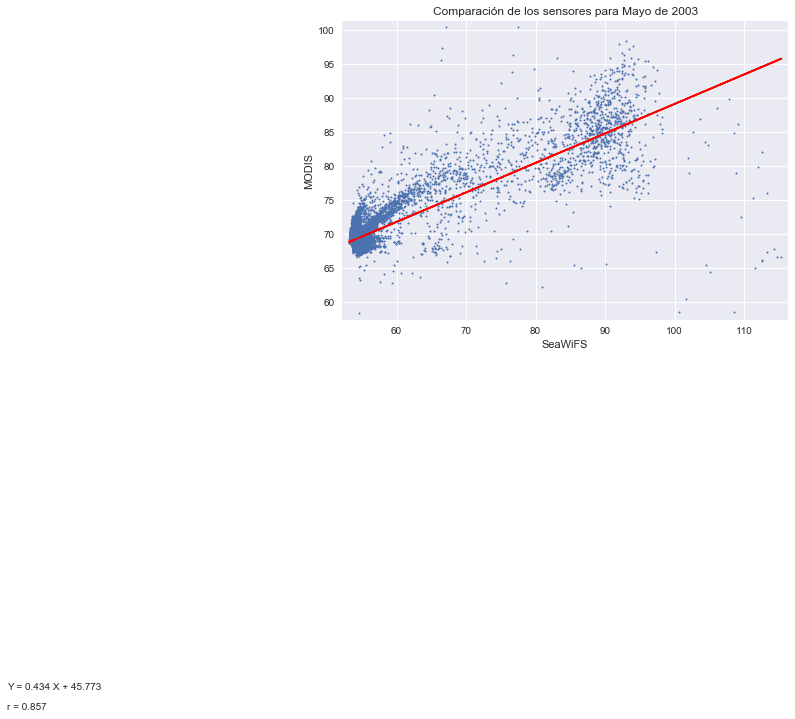

In [82]:
# Para el sensor SeaWiFS.

with open('MAYO 2003/SeaWiFS/Composicion (Lt_490).txt') as archivo_seawifs:
    for _ in range(5):
        # Ignoramos los primeros 5 renglones del archivo.
        archivo_seawifs.readline()
    # Separamos los datos en una matriz.
    datos_seawifs = np.array([archivo_seawifs.readline().split()
                              for _ in range(127)])

# Desenrrollamos y convertimos a reales.
datos_seawifs = datos_seawifs.ravel()
datos_seawifs = np.array([float(dat) for dat in datos_seawifs])

# Para el sensor MODIS. Es lo mismo pero con otro archivo.

with open('MAYO 2003/MODIS/Composicion (B10).txt') as archivo_modis:
    for _ in range(5):
        # Ignoramos los primeros 5 renglones del archivo.
        archivo_modis.readline()
    # Separamos los datos en una matriz.
    datos_modis = np.array([archivo_modis.readline().split()
                              for _ in range(127)])

# Desenrrollamos y convertimos a reales.
datos_modis = datos_modis.ravel()
datos_modis = np.array([float(dat) for dat in datos_modis])

# Calculamos los coeficientes del ajuste lineal
a, b = np.polyfit(datos_seawifs, datos_modis, 1)
# Calculamos el coeficiente de correlación
r = np.corrcoef(datos_seawifs, datos_modis)

plt.plot(datos_seawifs, datos_modis, linestyle='', marker='o', markersize=2)

plt.xlim(np.min(datos_seawifs) - 1, np.max(datos_seawifs) + 1)
plt.ylim(np.min(datos_modis) - 1, np.max(datos_modis) + 1)

plt.xlabel("SeaWiFS")
plt.ylabel("MODIS")

plt.title("Comparación de los sensores para Mayo de 2003")

plt.text(4, 0, 'r = {0:2.3f}'.format(r[0,1]))
plt.text(4, 3, 'Y = {0:2.3f} X + {1:2.3f}'.format(a, b))

# El ajuste calculado.
plt.plot(datos_seawifs, a * datos_seawifs + b, "r")

### Comparación para el mes de Junio

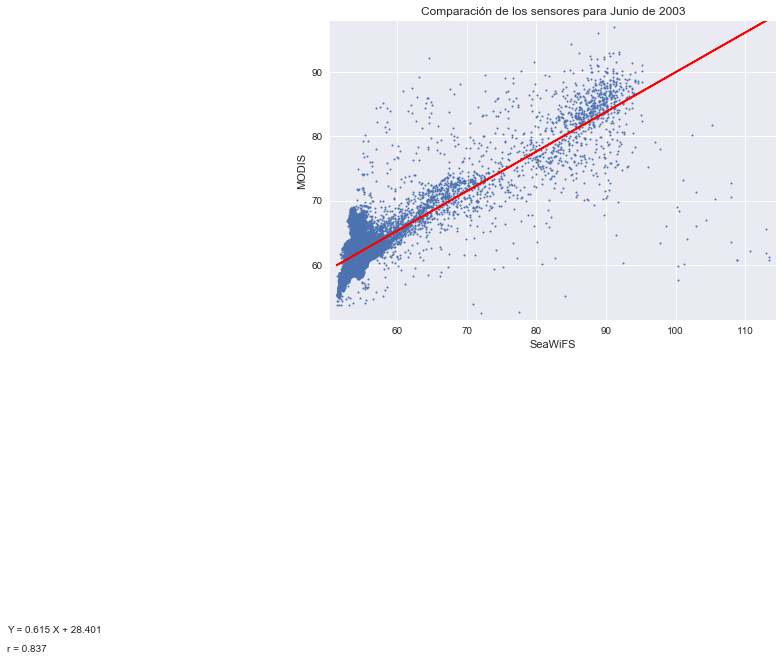

In [83]:
# Para el sensor SeaWiFS.

with open('JUNIO 2003/SeaWiFS/Composicion (Lt_490).txt') as archivo_seawifs:
    for _ in range(5):
        # Ignoramos los primeros 5 renglones del archivo.
        archivo_seawifs.readline()
    # Separamos los datos en una matriz.
    datos_seawifs = np.array([archivo_seawifs.readline().split()
                              for _ in range(127)])

# Desenrrollamos y convertimos a reales.
datos_seawifs = datos_seawifs.ravel()
datos_seawifs = np.array([float(dat) for dat in datos_seawifs])

# Para el sensor MODIS. Es lo mismo pero con otro archivo.

with open('JUNIO 2003/MODIS/Composicion (B10).txt') as archivo_modis:
    for _ in range(5):
        # Ignoramos los primeros 5 renglones del archivo.
        archivo_modis.readline()
    # Separamos los datos en una matriz.
    datos_modis = np.array([archivo_modis.readline().split()
                              for _ in range(127)])

# Desenrrollamos y convertimos a reales.
datos_modis = datos_modis.ravel()
datos_modis = np.array([float(dat) for dat in datos_modis])

# Calculamos los coeficientes del ajuste lineal
a, b = np.polyfit(datos_seawifs, datos_modis, 1)
# Calculamos el coeficiente de correlación
r = np.corrcoef(datos_seawifs, datos_modis)

plt.plot(datos_seawifs, datos_modis, linestyle='', marker='o', markersize=2)

plt.xlim(np.min(datos_seawifs) - 1, np.max(datos_seawifs) + 1)
plt.ylim(np.min(datos_modis) - 1, np.max(datos_modis) + 1)

plt.xlabel("SeaWiFS")
plt.ylabel("MODIS")

plt.title("Comparación de los sensores para Junio de 2003")

plt.text(4, 0, 'r = {0:2.3f}'.format(r[0,1]))
plt.text(4, 3, 'Y = {0:2.3f} X + {1:2.3f}'.format(a, b))

# El ajuste calculado.
plt.plot(datos_seawifs, a * datos_seawifs + b,"r")

### Se experimenta con la representacion de hexbin

In [11]:
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins = 300
k = kde.gaussian_kde([datos_seawifs, datos_modis])
xi, yi = np.mgrid[datos_seawifs.min():datos_seawifs.max():nbins*1j, datos_modis.min():datos_modis.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))


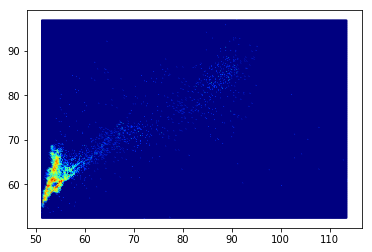

In [12]:
# Make the plot
plt.hexbin(datos_seawifs, datos_modis, gridsize=(300,300),bins="log",cmap="jet")
plt.show()

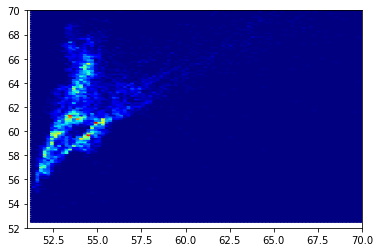

In [23]:
# We can control the size of the bins:

plt.hexbin(datos_seawifs, datos_modis, gridsize=(300,300),cmap="jet")
v=[51,70,52,70]
plt.axis(v)
plt.show()


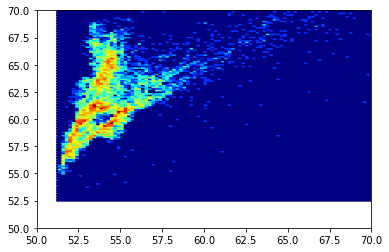

In [14]:
plt.hexbin(datos_seawifs, datos_modis, gridsize=(300,300),bins="log",cmap="jet")
v=[50,70,50,70]
plt.axis(v)
plt.show()